In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns
import IPython.display as ipd
from sklearn import preprocessing

import librosa, librosa.display

plt.rcParams['figure.figsize'] = (10, 3)

# Introduction

## Librosa Features

**Features**

- **Spectral Features**
    - Chromagram
        - **Chromagram STFT**: A chromagram from a waveform or power spectrogram

        - **Constant-Q chromagram**

        - **Chroma Energy Normalized (CENS)**

        - **Variable-Q chromagram**

    - **Mel-scaled spectrogram**
  
    - **Mel-frequency cepstral coefficients (MFCCs)**

    - **RMS**: Root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S
    
    - Spectrogram features
        - **Spectral centroid**

        - **Spectral bandwidth** of p'th-order

        - **Spectral contrast**

        - **Spectral flatness**

        - **Roll-off frequency**

        - **Polynomial features**: Coefficients of fitting an nth-order polynomial to the columns of a spectrogram

    - **Tonnetz**: The tonal centroid features (tonnetz)

    - **Zero crossing rate:** The zero-crossing rate of an audio time series

- **Rhythm features**
    - **Tempo**: the tempo (beats per minute)
    - **Tempogram**: local autocorrelation of the onset strength envelope
    - **Fourier Tempogram**: the short-time Fourier transform of the onset strength envelope
    - **Tempogram Ratio**: also known as spectral rhythm patterns

**Decomposition**
- Median-filtering **harmonic percussive source separation** (HPSS)

**Feature Statistics**

- Mean
- Standard Deviation
- Skewness
- Kurtosis

## Feature Extraction

1. First, an audio is decomposed to harmonic part and percussive part. Then we have three audio(signal) time series `y`.

2. For each time series (`y`, `y_harm`, `y_perc`), compute features introduced above.

3. The features can be a scalar, a vector. In the case of the latter, generate mean, standard deviaton, skewness and kurtosis of each feature vector.

# Audio Example

Let's look at an example of a single audio wav file.

In [14]:
path_audio = "data/Endless/07. Comme des Garcons.mp3"

In [25]:
y, sr = librosa.load(path_audio, duration=30)
y = librosa.effects.trim(y)[0] # check if there is silence before or after the actual audio

In [26]:
ipd.Audio(y, rate=sr)

In [27]:
print(f"- digital signals information - \n audio time series length: {len(y)} \n sample rate: {sr} \n audio length: {len(y)/sr}")

- digital signals information - 
 audio time series length: 661500 
 sample rate: 22050 
 audio length: 30.0


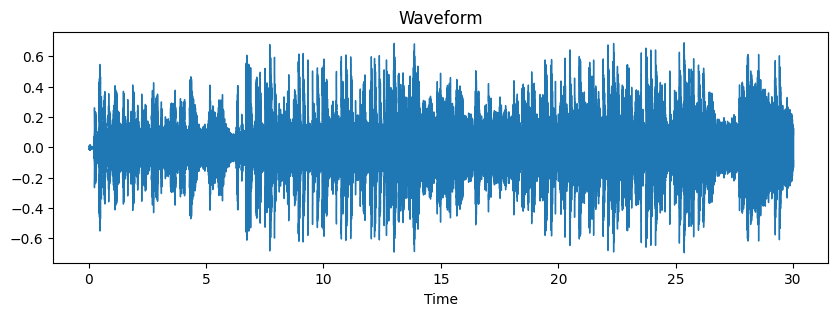

In [28]:
plt.title('Waveform')
librosa.display.waveshow(y=y,sr=sr)
plt.show()

In [64]:
# fft parameters
n_fft = 2048
hop_length = 512

# STFT
# The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
D = librosa.stft(y=y, n_fft=2048, hop_length=hop_length, window='hann', center=True) #stft coefficient

# Amplitude
S, _ = librosa.magphase(D, power=1) # S = np.abs(D) energy
S_pw, _ = librosa.magphase(D, power=2) # S = np.abs(D)**2 power

In [65]:
print(S.shape)

(1025, 1292)


In [66]:
# Convert an amplitude spectrogram to dB-scaled spectrogram
S_dB = librosa.amplitude_to_db(S, ref=np.max)

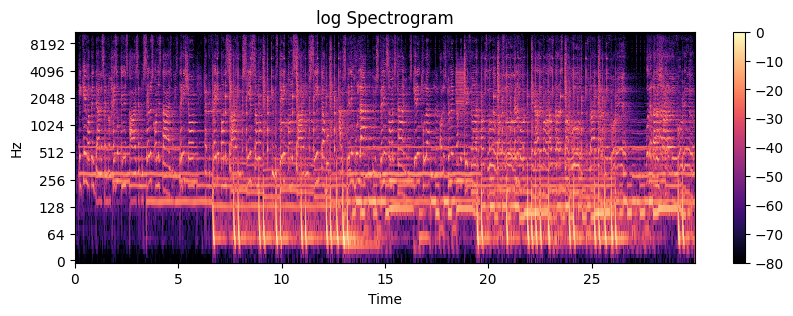

In [67]:
plt.title('log Spectrogram')
librosa.display.specshow(data=S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

The Mel spectrogram is a spectrogram with a Mel scale on the y axis.

In [68]:
mel_S = librosa.feature.melspectrogram(y=y, sr=sr)
# or (same output)
mel_S = librosa.feature.melspectrogram(S=S) 

mel_S_dB = librosa.amplitude_to_db(mel_S, ref=np.max)

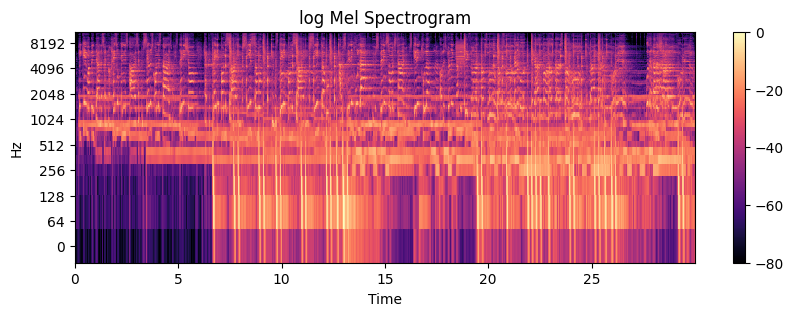

In [69]:
plt.title('log Mel Spectrogram')
librosa.display.specshow(mel_S_dB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.show()

# Harmonic-Percussive Source Separation

## Harmonics-Percussive Source Separation

In [31]:
def hpss(y, margin=1.0):
    """
    Median-filtering harmonic percussive source separation (HPSS).

    If ``margin = 1.0``, decomposes an input spectrogram ``S = H + P``
    where ``H`` contains the harmonic components,
    and ``P`` contains the percussive components.

    If ``margin > 1.0``, decomposes an input spectrogram ``S = H + P + R``
    where ``R`` contains residual components not included in ``H`` or ``P``.
    """
    y_harm, y_perc = librosa.effects.hpss(y=y, margin=margin)
    out = (y_harm, y_perc)
    return out

In [60]:
y_harm, y_perc = hpss(y, margin=1)

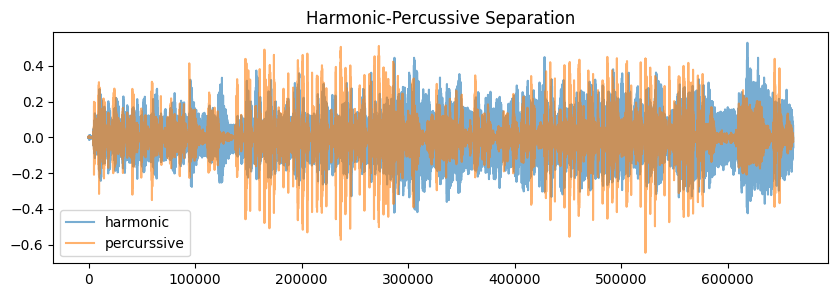

In [61]:
plt.title('Harmonic-Percussive Separation')
plt.plot(y_harm, alpha=.6)
plt.plot(y_perc, alpha=.6)
plt.legend(['harmonic','percurssive'])
plt.show()

In [62]:
# Harmonic
print("Harmonic")
ipd.display(ipd.Audio(data=y_harm, rate=sr))
# Percussive
print("Percussive")
ipd.display(ipd.Audio(data=y_perc, rate=sr))

Harmonic


Percussive


In [63]:
print(f"- Harmonic y -\n shape: {y_harm.shape} \n mean: {np.mean(y_harm)} \n variance: {np.var(y_harm)}")
print()
print(f"- Percussive y -\n shape: {y_perc.shape} \n mean: {np.mean(y_perc)} \n variance: {np.var(y_perc)}")

- Harmonic y -
 shape: (661500,) 
 mean: -2.2902308955963235e-06 
 variance: 0.006025113631039858

- Percussive y -
 shape: (661500,) 
 mean: -3.989521246694494e-06 
 variance: 0.0031081787310540676


# Features - Spectral Features

## Zero crossing rate

In [170]:
zero_crossings = librosa.zero_crossings(y=y, pad=False)
print(sum(zero_crossings))

65095


In [171]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
print(f"- Zero Crossing Rate -\n shape: {zero_crossing_rate.shape} \n mean: {np.mean(zero_crossing_rate)} \n variance: {np.std(zero_crossing_rate)**2}")

- Zero Crossing Rate -
 shape: (1, 1293) 
 mean: 0.0982227015661253 
 variance: 0.0004313937769114764


In [172]:
# check
print(features.zero_crossing_rate_mean.values, features.zero_crossing_rate_var.values)

[0.0982227] [0.00043139]


In [176]:
# check
print(features.harmony_mean.values, features.harmony_var.values)
print(features.perceptr_mean.values, features.perceptr_var.values)

[-4.66024067e-05] [0.00122963]
[-0.0001211] [6.0270424e-05]


not exactly same, but close

## BPM tempo

In [177]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, units='time')
print('BPM:', tempo)

BPM: 95.703125


In [178]:
print(features.tempo.values)

[95.703125]


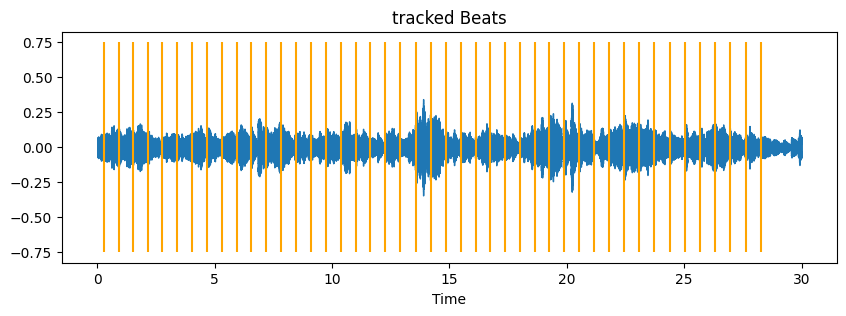

In [179]:
plt.title('tracked Beats')
librosa.display.waveshow(y=y,sr=sr)
plt.vlines(beats, ymin=-.75,ymax=.75, color='orange')
plt.show()

## Spectral centroids

In [180]:
# Calculate the Spectral Centroids
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
# or (same output)
centroid = librosa.feature.spectral_centroid(S=S)[0]

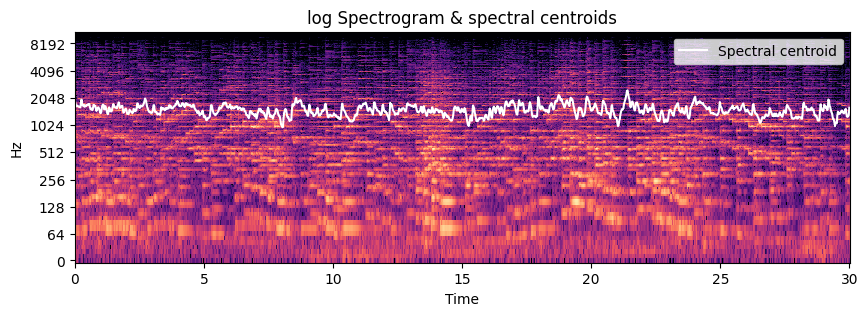

In [181]:
times = librosa.times_like(centroid)
fig, ax = plt.subplots()
librosa.display.specshow(S_dB, y_axis='log', x_axis='time', ax=ax)
ax.plot(times, centroid.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Spectrogram & spectral centroids')
plt.show()

In [182]:
print(f"- Spectral Centroids y -\n shape: {centroid.shape} \n mean: {np.mean(centroid)} \n variance: {np.var(centroid)}")

- Spectral Centroids y -
 shape: (1293,) 
 mean: 1505.3574607063904 
 variance: 44430.73283264563


In [183]:
print(features.spectral_centroid_mean.values, features.spectral_bandwidth_var.values)

[1505.16642397] [43682.97326723]


not exactly same but close

## spectral bandwith

In [184]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

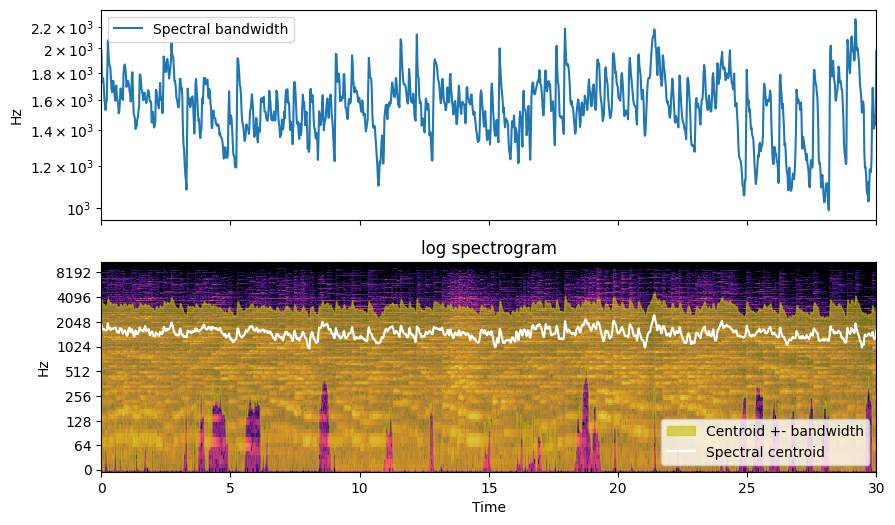

In [185]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,6))
times = librosa.times_like(spec_bw)
ax[0].semilogy(times, spec_bw, label='Spectral bandwidth') #log-scaled
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(S_dB, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid - spec_bw),
                np.minimum(centroid + spec_bw, sr/2),
                alpha=0.6, label='Centroid +- bandwidth', color='y')
ax[1].plot(times, centroid, label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

In [186]:
print(f"- Spectral Bandwidth y -\n shape: {spec_bw.shape} \n mean: {np.mean(spec_bw)} \n variance: {np.var(spec_bw)}")

- Spectral Bandwidth y -
 shape: (1293,) 
 mean: 1559.2288947162588 
 variance: 43765.37312635112


In [187]:
print(features.spectral_bandwidth_mean.values, features.spectral_bandwidth_var.values)

[1559.00574034] [43682.97326723]


## Spectral rolloff

In [188]:
# Spectral Roll-Off Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]

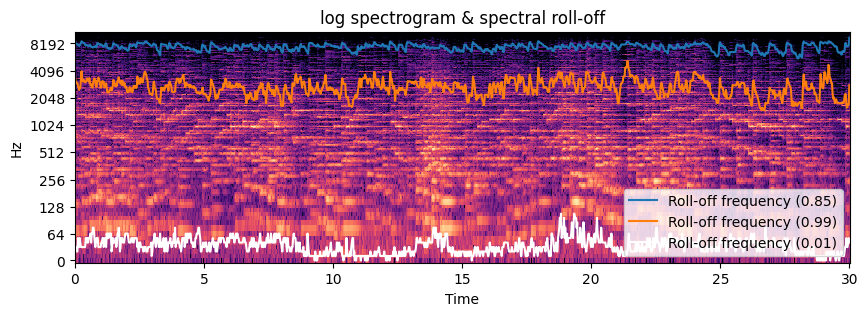

In [189]:
times = librosa.times_like(spectral_rolloff)

rolloff_max = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                          y_axis='log', x_axis='time', ax=ax)
ax.plot(times, rolloff_max[0], label='Roll-off frequency (0.85)')
ax.plot(times, spectral_rolloff, label='Roll-off frequency (0.99)')
ax.plot(times, rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log spectrogram & spectral roll-off')
plt.show()

In [190]:
print(f"- Spectral Roll-off y -\n shape: {spectral_rolloff.shape} \n mean: {np.mean(spectral_rolloff)} \n variance: {np.var(spectral_rolloff)}")

- Spectral Roll-off y -
 shape: (1293,) 
 mean: 2717.238763866734 
 variance: 299014.0000693897


In [191]:
print(features.rolloff_mean.values, features.rolloff_var.values)

[2716.30615801] [299398.30722597]


## MFCC (Mel-Frequency Cepstral Coefficients) 20

In [192]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
print('mfccs shape:', mfccs.shape)

mfccs shape: (20, 1293)


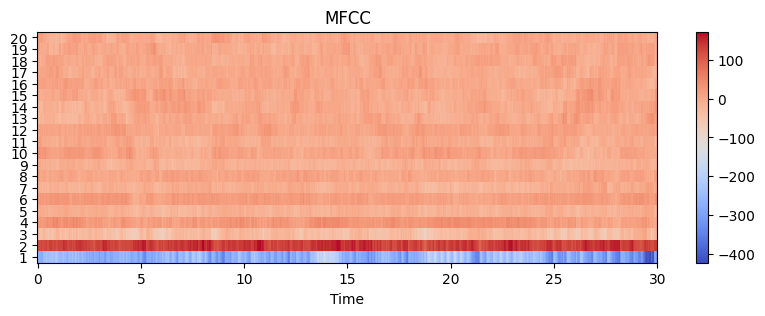

In [193]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
ax.set_yticks(range(0,20), labels=range(1,21))
plt.show()

In [194]:
for i in range(20):
    print(f"MFCC {i+1} \n mean: {mfccs[i].mean()}, variance: {mfccs[i].var()}")
    print()

MFCC 1 
 mean: -268.21856689453125, variance: 1791.935791015625

MFCC 2 
 mean: 135.68165588378906, variance: 188.9014129638672

MFCC 3 
 mean: -34.05637741088867, variance: 231.39031982421875

MFCC 4 
 mean: 25.616008758544922, variance: 169.41429138183594

MFCC 5 
 mean: -12.971722602844238, variance: 71.249267578125

MFCC 6 
 mean: 17.903263092041016, variance: 74.56208801269531

MFCC 7 
 mean: -9.990859985351562, variance: 114.86932373046875

MFCC 8 
 mean: 5.634088039398193, variance: 65.84175872802734

MFCC 9 
 mean: -14.143672943115234, variance: 75.42843627929688

MFCC 10 
 mean: 7.493185043334961, variance: 177.2174530029297

MFCC 11 
 mean: -3.9764394760131836, variance: 106.70967102050781

MFCC 12 
 mean: 8.258308410644531, variance: 80.11543273925781

MFCC 13 
 mean: -1.3336011171340942, variance: 154.7423095703125

MFCC 14 
 mean: -0.35799506306648254, variance: 188.39491271972656

MFCC 15 
 mean: 1.0361007452011108, variance: 171.72482299804688

MFCC 16 
 mean: 3.79682254

In [195]:
features.iloc[:,19:-1].T

100
mfcc1_mean   -268.195526
mfcc1_var    1792.286011
mfcc2_mean    135.691971
mfcc2_var     189.090881
mfcc3_mean    -34.051403
mfcc3_var     231.440308
mfcc4_mean     25.615507
mfcc4_var     169.200241
mfcc5_mean    -12.977585
mfcc5_var      71.468498
mfcc6_mean     17.902988
mfcc6_var      74.706894
mfcc7_mean     -9.990349
mfcc7_var     114.750702
mfcc8_mean      5.630702
mfcc8_var      65.850983
mfcc9_mean    -14.142573
mfcc9_var      75.537086
mfcc10_mean     7.490304
mfcc10_var    177.036102
mfcc11_mean    -3.969332
mfcc11_var    106.864899
mfcc12_mean     8.258574
mfcc12_var     80.119263
mfcc13_mean    -1.335326
mfcc13_var    154.534012
mfcc14_mean    -0.365052
mfcc14_var    188.326233
mfcc15_mean     1.039341
mfcc15_var    171.780548
mfcc16_mean     3.791384
mfcc16_var     86.137909
mfcc17_mean    -0.320783
mfcc17_var    100.827087
mfcc18_mean     1.772985
mfcc18_var     95.440735
mfcc19_mean     0.889234
mfcc19_var     97.133331
mfcc20_mean    -0.842025
mfcc20_var    120.865791

pretty much same

## Chroma stft

In [196]:
# Chromogram
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=1024)
# or (same output)
chromagram = librosa.feature.chroma_stft(S=S_pw, hop_length=1024) # Increase hop_length
print('Chromogram shape:', chromagram.shape)

Chromogram shape: (12, 1293)


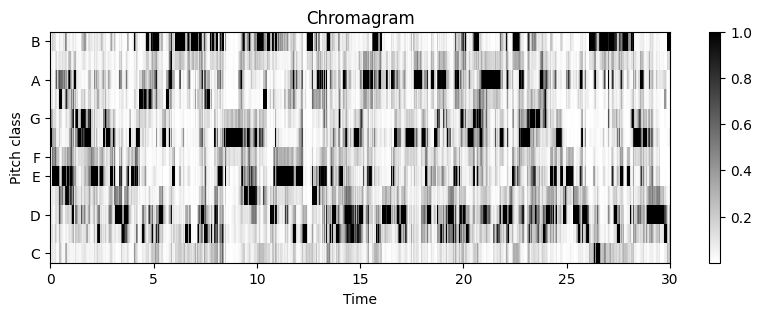

In [197]:
plt.title("Chromagram")
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', cmap='gray_r')
plt.colorbar()
plt.show()

In [198]:
print(f"- Chroma STFT - \n mean: {chromagram.mean()}, variance: {chromagram.var()}")

- Chroma STFT - 
 mean: 0.25236058235168457, variance: 0.08414862304925919


In [199]:
print(features.chroma_stft_mean.values, features.chroma_stft_var.values)

[0.25239193] [0.08415318]


## RMS

root-mean-square (RMS) value for each frame

In [200]:
rms = librosa.feature.rms(y=y)
# or (same output)
rms = librosa.feature.rms(S=librosa.stft(y, window=np.ones, center=False))

Text(0.5, 0, 'Time')

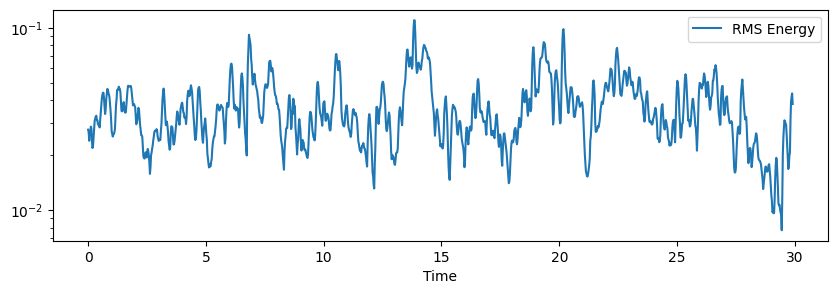

In [201]:
fig, ax = plt.subplots()
times = librosa.times_like(rms)
ax.semilogy(times, rms[0], label='RMS Energy') # log scaled
ax.legend()
ax.set_xlabel('Time')

In [202]:
print(f"- RMS - \n mean: {rms.mean()}, variance: {rms.var()}")

- RMS - 
 mean: 0.03627101697429944, variance: 0.00022120456304595005


In [203]:
print(features.rms_mean.values, features.rms_var.values)

[0.03624489] [0.00022075]
